In [1]:
# a small tutorial on how to use the main class of the repo "PathShadowing"
# this is done on very bad generated data ("gaussian") so don't trust the results
# use this code with your own data (both generated and observed)
import os
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
import warnings

import pandas as pd
import yfinance as yf

warnings.filterwarnings("ignore")

from scatspectra import PriceData, MRWGenerator
from shadowing import (
    Softmax,
    compute_smile,
    PathShadowing,
    Foveal,
    RelativeMSE,
    PredictionContext,
    ArrayType,
)
from shadowing.utils import windows

CACHE_PATH = Path(os.getcwd()) / "_cache"  # replace with your own cache path


def _torch(x: ArrayType) -> torch.Tensor:
    """Convert x to a torch float tensor."""
    if isinstance(x, torch.Tensor):
        return x
    return torch.tensor(x, dtype=torch.float32)

#ignoring the warnings
warnings.filterwarnings("ignore")

/var/folders/zw/dpjp09bn4_l8yjw9zyyrfcmr0000gn/T/ipykernel_6700/3990929936.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


<span style="color:red">

# 1. Generated Dataset

<span>

<span style="color:Black">
The generated data to look for close time-series ("shadowing" paths).

You should come up with your own generated market data (log-prices). 

Here we generate data from a multifractal random walk (MRW) for simplicity,

of course, one should perform path shadowing in a more accurate model e.g. Scattering Spectra model. 
<span>

Model MRW: using cache directory MRW_B64_T4097_L4097_H5_0e_01_la2_0e_01.
Dataset shape (nb_long_time_series, nb_channels, nb_times):  (2048, 1, 4096)


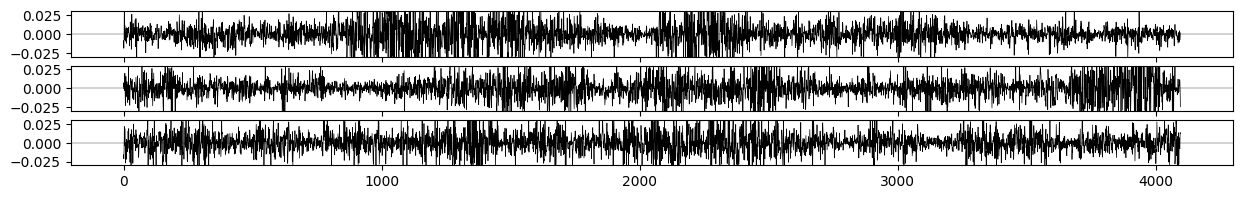

In [2]:
# create synthetic dataset
R = 2048

lnx_mrw = MRWGenerator(T=4096 + 1, H=0.5, lam=0.2, cache_path=CACHE_PATH).load(R=R)  # generate the MRW
dlnx_mrw = np.diff(lnx_mrw, axis=-1)  # compute the increments
print("Dataset shape (nb_long_time_series, nb_channels, nb_times): ", dlnx_mrw.shape)

# plotting some of the MRW paths
fig, axes = plt.subplots(3, 1, figsize=(15, 2))
for i, ax in enumerate(axes):
    ax.plot(dlnx_mrw[i, 0, :], color="black", linewidth=0.5)
    ax.axhline(0.0, color="black", linewidth=0.25)
    ax.set_ylim(-0.03, 0.03)

<span style="color:red">

**Notes:**
Dans la fonction *MRWGenerator* on génère T trajectoires de longueur R, avec les paramètres H (exposant de Hurst) et alpha (paramètre de la distribution des sauts). 

*Proposition de modifications à apporter:*
- La fonction devrait théoriquement générer des vecteurs de vecteurs, cependant celle-ci rajoute un vecteur de plus d'où un shape de (R, 1, T) au lieu de (R, T).
</span>

Model MRW: generating data ...


Finished.
Context shape (nb_dates, nb_channels, nb_times):  (4, 1, 126)


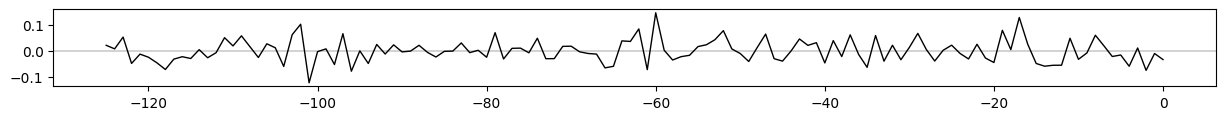

In [3]:
# observed data e.g. past time-series at different dates
# replace with the data you want to predict the future of
lnx_context_1 = MRWGenerator(T=252 + 1, H=0.5, lam=0.2).load(R=1)
dlnx_context = np.diff(lnx_context_1, axis=-1)
dlnx_context = windows(dlnx_context, w=126, s=32)[0, 0, :, None, :]
print("Context shape (nb_dates, nb_channels, nb_times): ", dlnx_context.shape)

plt.figure(figsize=(15, 1))
plt.plot(np.arange(-126 + 1, 1), dlnx_context[1, 0, :], color="black", linewidth=1.0)
plt.axhline(0.0, color="black", linewidth=0.25)

**Generating dataset for SPX Index prices**

[*********************100%%**********************]  1 of 1 completed


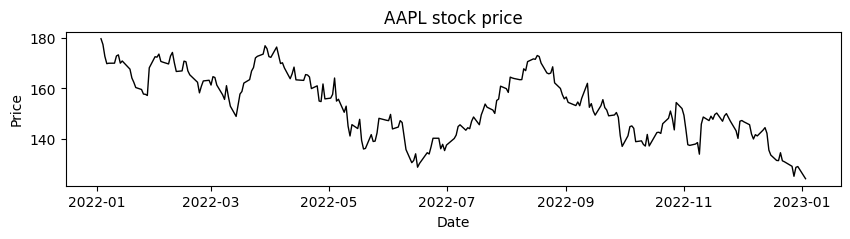

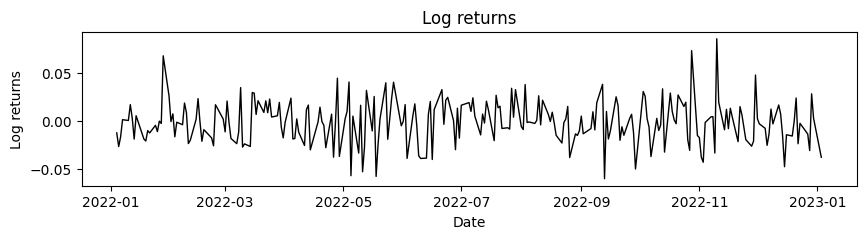

In [4]:
# getting data from 2022 to 2024
spx = yf.download("AAPL", start="2022-01-01", end="2023-01-04")

#calculating the log returns
spx["log_ret"] = np.log(spx["Adj Close"]) - np.log(spx["Adj Close"].shift(1))

#plotting data
plt.figure(figsize=(10, 2))
plt.plot(spx["Adj Close"], color="black", linewidth=1.0)
plt.title("AAPL stock price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

#plotting the log returns
plt.figure(figsize=(10, 2))
plt.plot(spx["log_ret"], color="black", linewidth=1.0)
plt.title("Log returns")
plt.xlabel("Date")
plt.ylabel("Log returns")
plt.show()

In [5]:
spx_context = windows(np.array(spx["log_ret"]), w=126, s=32)
print("Context shape (nb_dates, nb_channels, nb_times): ", spx_context.shape)

Context shape (nb_dates, nb_channels, nb_times):  (4, 126)


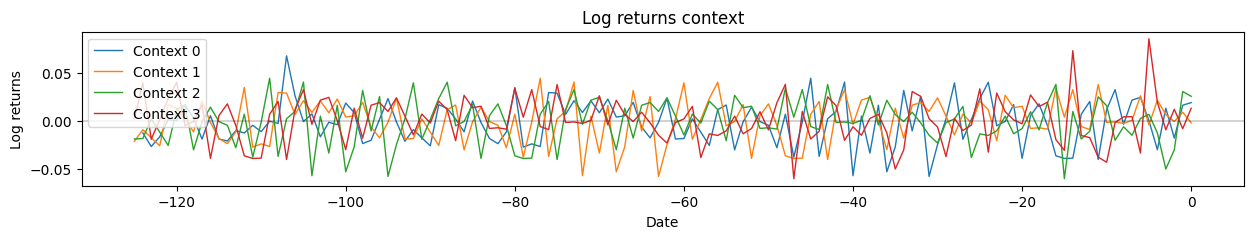

In [6]:
#plotting the context  
plt.figure(figsize=(15, 2))
for i in range(4):
    plt.plot(np.arange(-126 + 1, 1), spx_context[i], linewidth=1.0, label="Context " + str(i))
plt.axhline(0.0, color="black", linewidth=0.25)
plt.legend()
plt.title("Log returns context")
plt.xlabel("Date")
plt.ylabel("Log returns")
plt.show()

In [7]:
dlnx_mrw[0][0]

array([-0.00877071, -0.01896962, -0.00755306, ..., -0.00813196,
       -0.00238025,  0.00134092])

# 2. Path Shadowing

Given observed log-returns gather the closest paths from the generated dataset.

**Defining the embedding function and the distance function:**

In [8]:
# embedding for dimensionality reduction
embedding = Foveal(
    alpha=1.15,  # cover the past at exponential speed
    beta=0.9,  # look with a weight power-law decay of 0.9
    max_context=126,  # look at half-year in the observed past
)

# distance between embedded paths
distance = RelativeMSE()

**On MRW data**

In [9]:
# object for path shadowing
obj_MRW = PathShadowing(
    embedding=embedding,
    distance=distance,
    dataset=dlnx_mrw,
    context=PredictionContext(horizon=252),  # the size of such paths in the future
)

# PERFORM PATH SHADOWING
distances_MRW, close_paths_MRW = obj_MRW.shadow(
    dlnx_context,
    k=8192,  # the number of closest paths (from generated dataset) to retain
    n_splits=8,
    cuda=False,  # set to True, if GPU available, for accelarations
)

**On SPX data**

In [10]:
#On SPX data
obj_spx = PathShadowing(
    embedding=embedding,
    distance=distance,
    dataset=np.array(spx["log_ret"]),
    context=PredictionContext(horizon=252),  # the size of such paths in the future
)

# PERFORM PATH SHADOWING
distances_spx, close_paths_spx = obj_spx.shadow(
    spx_context,
    k=8192,  # the number of closest paths (from generated dataset) to retain
    n_splits=1,
    cuda=False,  # set to True, if GPU available, for accelarations
)

RuntimeError: Calculated padded input size per channel: (252). Kernel size: (378). Kernel size can't be greater than actual input size

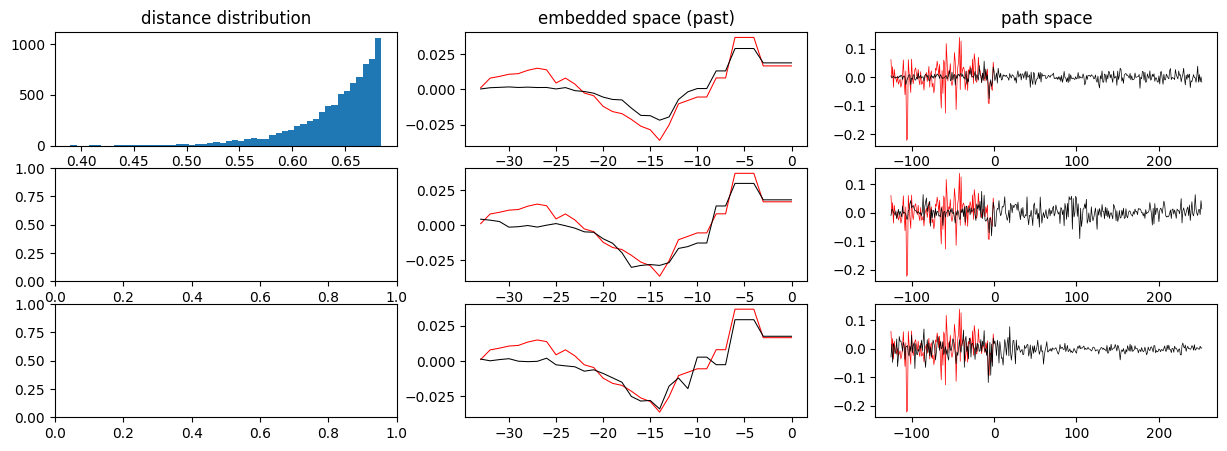

In [ ]:
# some vizualization
i_date = 0

context_size = dlnx_context.shape[-1]  # nb of days in the past
d = embedding.dim  # embedding dimension
horizon = 252

# get 3 closest paths at this date
idces = np.argpartition(distances[i_date, :], 3)[:3]
dlnx_closest = np.stack([close_paths[i_date][i_path] for i_path in idces])

# embed them
dlnx_context_emb = embedding(_torch(dlnx_context))
dlnx_closest_emb = embedding(_torch(dlnx_closest))

fig, axes = plt.subplots(3, 3, figsize=(15, 5))
axes[0, 0].set_title("distance distribution")
axes[0, 0].hist(distances[i_date], bins=50)
axes[0, 1].set_title("embedded space (past)")
for i, ax in enumerate(axes[:, 1]):
    ts_past = np.arange(-d + 1, 1)
    ax.plot(
        ts_past, dlnx_context_emb[i_date, 0, :].flip(-1), color="red", linewidth=0.75
    )
    ax.plot(ts_past, dlnx_closest_emb[i, 0, :].flip(-1), color="black", linewidth=0.75)
axes[0, 2].set_title("path space")
for i, ax in enumerate(axes[:, 2]):
    ts_past = np.arange(-context_size + 1, 1)
    ts = np.arange(-context_size + 1, horizon + 1)
    ax.plot(ts_past, dlnx_context[i_date, 0, :], color="red", linewidth=0.5)
    ax.plot(ts, dlnx_closest[i, 0, :], color="black", linewidth=0.5)

# Volatility Prediction

In [ ]:
from shadowing.statistics import realized_variance

# maturities
Ts = np.array([7, 25, 75])

# the quantity to predict, should be a function of paths returning an array of statistics
# e.g. realized variance, takes a path, return a scalar per maturity
to_predict = lambda dlnx: realized_variance(dlnx, Ts=Ts, vol=True)

# perform prediction by averaging over the k closest paths for each prediction date
# see method 'predict' for more direct way
predictions, _ = obj.predict_from_paths(
    distances, close_paths, to_predict=to_predict, proba_name="softmax", eta=0.1
)

print(f"n_dates={predictions.shape[0]}, nb_maturities={predictions.shape[1]}")

n_dates=4, nb_maturities=3


# Option Pricing

Shows how to perform option pricing in two contexts


In [ ]:
Ts = np.array([7, 25, 75])  # maturities in days
Ms = np.linspace(-2.0, 2.0, 9)  # rescaled log-moneyness
r = 0.00  # interest rate

### Smile at a given date

(0.0, 0.6)

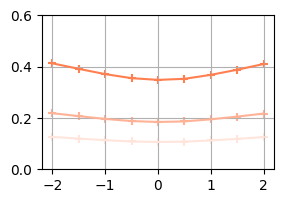

In [ ]:
i_date = 0

# averaging operator in Hedged HMC
ave = Softmax(distances[i_date, :], eta=0.075)

# the shadowing paths extending the currently observed past
x = PriceData(dlnx=close_paths[i_date, :, 0, context_size:], x_init=100.0).x

# HMC on such shadowing paths
smile_conditional = compute_smile(x, Ts, Ms, r, ave)

# plotting
_, ax = plt.subplots(1, 1, figsize=(3, 2))
smile_conditional.plot(ax=ax, color="coral", rescale=True)
ax.set_ylim(0.0, 0.6)

### Average Smile

(0.0, 0.6)

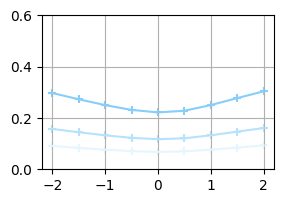

In [ ]:
# snippets of MRW price trajectories
lnx_mrw_snippets = windows(lnx_mrw[0, 0, :], w=252, s=1)
x = PriceData(lnx=lnx_mrw_snippets, x_init=100.0).x

# HMC on such snippets
smile_avg = compute_smile(x, Ts, Ms, r, ave=None)

# plotting
_, ax = plt.subplots(1, 1, figsize=(3, 2))
smile_avg.plot(ax=ax, color="lightskyblue", rescale=True)
ax.set_ylim(0.0, 0.6)